# arXiv Monthly Submissions & Downloads: Part 2

In [1]:
# Imports
import time_series as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
from beakerx import *
from warnings import filterwarnings

# Settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)
filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Data
df = pd.read_csv('combined_submissions_and_downloads.csv')
rows, columns = df.shape
f'Rows: {rows}, Columns: {columns}'

'Rows: 295, Columns: 4'

In [3]:
# Changing month to 'datetime'
ts.convert_to_datetime(data=df, column='month')

In [4]:
# Time series
downloads = ts.create_series(data=df, time_column='month', category_column='downloads')
submissions = ts.create_series(data=df, time_column='month', category_column='submissions')

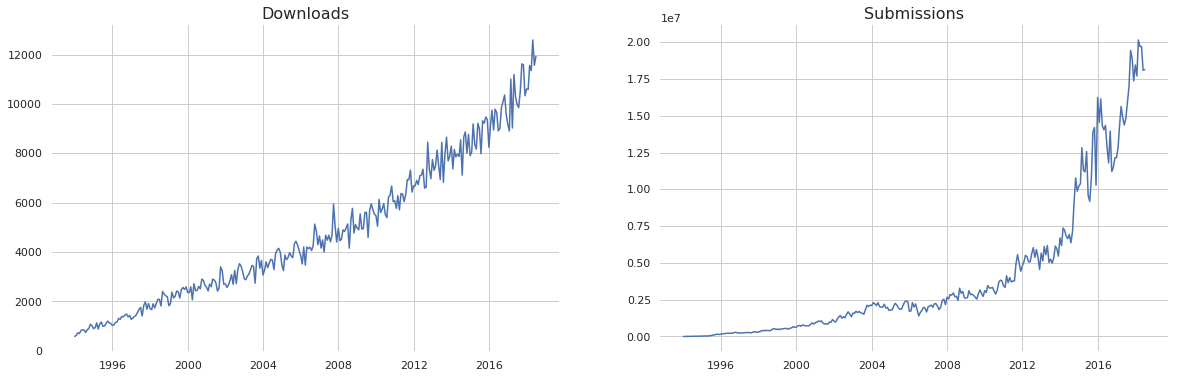

In [5]:
# Plotting
def plot_time_series(data_1, data_2, title_1, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_title(title_1, fontsize=16), ax2.set_title(title_2, fontsize=16)
    ax1.spines['top'].set_visible(False), ax2.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False), ax2.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False), ax2.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False), ax2.spines['left'].set_visible(False)
    sns.lineplot(data=data_1, ax=ax1)
    sns.lineplot(data=data_2, ax=ax2)
    
plot_time_series(submissions, downloads, 'Downloads', 'Submissions')

In [6]:
# Only runs in Jupyter Notebook not in Jupyter Lab
plot1 = TimePlot(title='Submissions', yLabel='Frequency')
plot1.add(Line(submissions))

In [7]:
# Only runs in Jupyter Notebook not in Jupyter Lab
plot2 = TimePlot(title='Downloads', yLabel='Frequency')
plot2.add(Line(downloads))

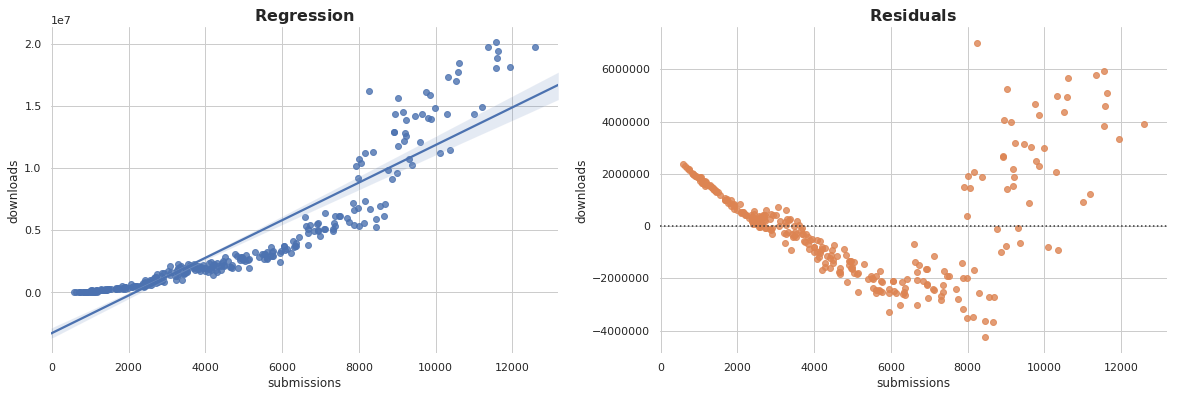

In [8]:
# Regression
def plot_regression(data_1, data_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_title(r'$\bf{Regression}$', fontsize=16)
    ax2.set_title(r'$\bf{Residuals}$', fontsize=16)
    ax1.spines['top'].set_visible(False), ax2.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False), ax2.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False), ax2.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False), ax2.spines['left'].set_visible(False)
    sns.regplot(x=data_1, y=data_2, ax=ax1)
    sns.residplot(x=data_1, y=data_2, ax=ax2)

plot_regression(submissions, downloads)

In [9]:
# Correlation
coef, p_val = pearsonr(x=submissions, y=downloads)
print(f'Coefficient: {coef},\tP-Value: {p_val}')

Coefficient: 0.91461559238573,	P-Value: 3.0097017741298825e-117


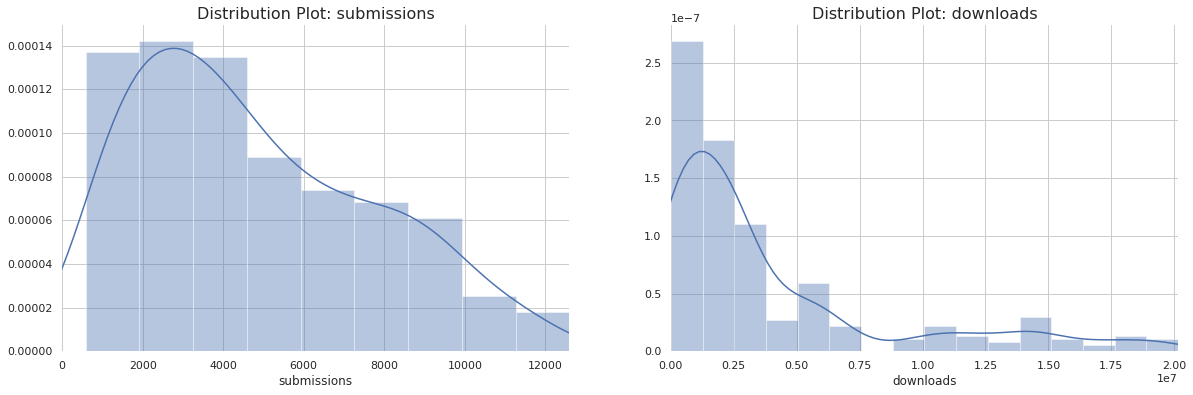

In [10]:
# Distribution
def plot_distribution(data_1, data_2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_title(f'Distribution Plot: {data_1.name}', fontsize=16)
    ax2.set_title(f'Distribution Plot: {data_2.name}', fontsize=16)
    ax1.spines['top'].set_visible(False), ax2.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False), ax2.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False), ax2.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False), ax2.spines['left'].set_visible(False)
    ax1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=True, left=False, right=False)
    ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=True, left=False, right=False)
    ax1.set_xlim(0, data_1.max()), ax2.set_xlim(0, data_2.max())
    sns.distplot(data_1, ax=ax1)
    sns.distplot(data_2, ax=ax2)

plot_distribution(submissions, downloads)

#### Train-Test Split

In [11]:
X, y = df[['submissions', 'historical_delta', 'downloads']], df['downloads']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True)

#### Evaluation Metrics

In [12]:
def evaluate_predictions(predictions, true):
    '''
    Calculates the Mean Absolute Error (MAE) &
    the Root Mean Squared Error (RMSE).
    '''
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean(predictions - true) ** 2)
    return mae, rmse

#### Naive Baseline Metrics

In [13]:
median_pred = X_train['downloads'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['downloads']

In [14]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 3123210.5676
Median Baseline RMSE: 1723981.5946


#### Machine Learning

In [15]:
# Evaluate
def evaluate(X_train, X_test, y_train, y_test):
    '''Evaluate the machine learning models for comparison.'''
    
    # Model names
    model_name_list = ['Linear',
                       'Ridge (L2)',
                       'Lasso (L1)',
                       'ElasticNet',
                       'Random Forest', 
                       'Extra Trees',
                       'SVM',
                       'Gradient Boosted',
                       'Baseline']
    
    # Fix data
    try:
        X_train = X_train.drop('downloads', axis=1)
        X_test = X_test.drop('downloads', axis=1)
    except:
        pass
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = Ridge()
    model3 = Lasso()
    model4 = ElasticNet(alpha=1., l1_ratio=.5)
    model5 = RandomForestRegressor(n_estimators=50)
    model6 = ExtraTreesRegressor(n_estimators=50)
    model7 = SVR(kernel='rbf', degree=3, C=1., gamma='auto')
    model8 = GradientBoostingRegressor(n_estimators=20)
    
    # Results dataframe
    results = pd.DataFrame(columns=['mae', 'rmse'], index=model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6, model7, model8]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Inserting results into dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
        
    # Median value baseline metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [16]:
results = evaluate(X_train, X_test, y_train, y_test)

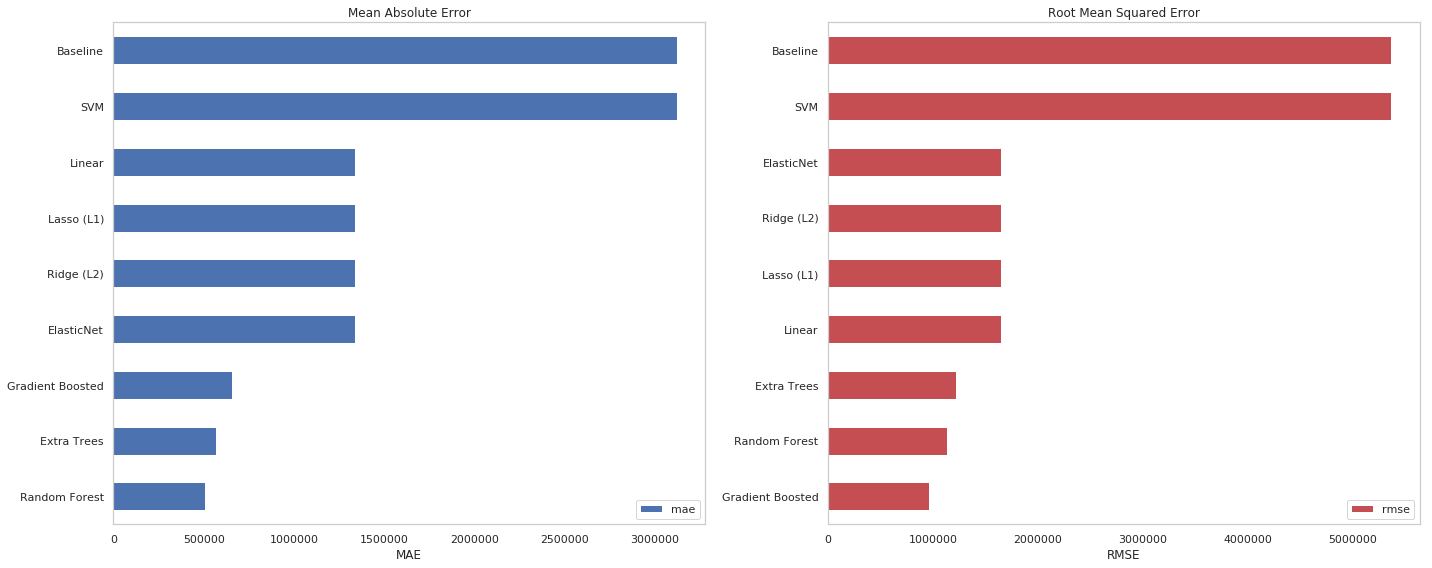

In [17]:
# Visualizing the results
# RMSE
plt.figure(figsize=(20, 8), edgecolor='black')
ax = plt.subplot(1, 2, 1)
results.sort_values('mae', ascending=True).plot.barh(y='mae', color='b', ax=ax)
plt.title('Mean Absolute Error')
plt.xlabel('MAE')
plt.grid()
plt.legend()

# MAE
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending=True).plot.barh(y='rmse', color='r', ax=ax)
plt.title('Root Mean Squared Error')
plt.xlabel('RMSE')
plt.grid()
plt.legend()

plt.tight_layout()

In [18]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Support Vector Machine is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['SVM', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Extra Trees are {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Extra Trees', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Random Forest is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Random Forest', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The ElasticNet Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['ElasticNet', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Ridge (L2) Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Ridge (L2)', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Lasso (L1) Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Lasso (L1)', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Linear Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Linear', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 79.03% better than the baseline.
The Support Vector Machine is 0.00% better than the baseline.
The Extra Trees are 81.85% better than the baseline.
The Random Forest is 83.68% better than the baseline.
The ElasticNet Regression is 57.13% better than the baseline.
The Ridge (L2) Regression is 57.12% better than the baseline.
The Lasso (L1) Regression is 57.12% better than the baseline.
The Linear Regression is 57.12% better than the baseline.
